In [68]:
import pandas as pd
import sklearn
from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Class of k-Nearest Neigbor Classifier
from sklearn import preprocessing

class kNN():
    def __init__(self, k = 3, exp = 2):
    # constructor for kNN classifier 
    # k is the number of neighbor for local class estimation
    # exp is the exponent for the Minkowski distance
        self.k = k
        self.exp = exp
      
    def fit(self, X_train, Y_train):
    # training k-NN method
    # X_train is the training data given with input attributes. n-th row correponds to n-th instance.
    # Y_train is the output data (output vector): n-th element of Y_train is the output value for n-th instance in X_train.
        self.X_train = X_train
        self.Y_train = Y_train   
         
    def getDiscreteClassification(self, X_test):
    # predict-class k-NN method
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs prediction vector Y_pred_test:  n-th element of Y_pred_test is the prediction for n-th instance in X_test
    
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []

   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
                 
            # the first element of the index predictions.index contains the class with the highest count; i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
    # computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2)
    
        # Set initial distance to 0
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance
    
    
    def normalize(self, X_train , X_test):
        #create new copies of the training sets 
        trainB = X_train.copy()
        testB = X_test.copy()
        max_value = X_train.max()
        min_value = X_train.min()
        
        #in order to make sure the normalization is correctly( in case of negative values) , we use the min and max
        #extract cols 
        for col in X_train.columns:
            rows = X_train.loc[:,col]
            newRows= (rows - min_value[col]).divide(max_value[col] - min_value[col])
            trainB.loc[:,col] = newRows
       
    #clip values to 1 or either 0
        for col in X_test.columns: 
            rows = X_test.loc[:, col]
            newRows = (rows - min_value[col]).divide(max_value[col] - min_value[col])
            newRows = np.clip(newRows, 0, 1)
            testB.loc[:,col] = newRows
            
            
        return testB, trainB 
    
    def getClassProbs(self, X_test, X_train, Y_train) : 
 #posterior prob for each class of data        
        posterior_prob = {} #thsi is a dictionary 
         
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = Y_train[df_knn.index].value_counts()
            
            num_of_occurances = self.Y_train[df_knn.index].value_counts()
            print(num_of_occurances)
           #dictionary that will contain all classes of the neighbours 
            prob_dic = dict()
            
            for instance, occurence in num_of_occurances : 
                probability = occurence / self.k 
                prob_dict[instance] = probability 
            posterior_prob[i] = prob_dic
            
            
        return pd.DataFrame(posterior_prob).fillna(0)
    
    
    def getPrediction(self, X_test): 
        
        prob_df = self.getClassProbs(X_test, self.X_train, self.Y_train)
        prob_dic = dict()
        
        #knn regression is done by (1/k) and sum(yi)
        for index, price_prob in prob_df.iteritems():
            sum_price = 0 
             #avg value of k nearest neigh of instance
            for price, prob in price_prob.items():
                if (prob != 0):
                    sum_price += price * prob 
            prob_dic[index] = sum_price 
        return pd.DataFrame.from_dict(prob_dic, orient = ' index') 
            

testing for accuracy performance when data is previously normalized andwhen it wasn't 

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('C:/Users/33789/OneDrive/Desktop/Machine Learning/glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter k for kNN

k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

trainAcc = np.zeros(len(k_range))
testAcc = np.zeros(len(k_range))
index = 0 

for k  in  k_range:
    clf = kNN(k)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
    
   #normalize the data before fitting
knn = kNN()
X_test, X_train = knn.normalize(X_test, X_train)

trainAccNorm = np.zeros(len(k_range))
testAccNorm = np.zeros(len(k_range))


index = 0 
for k  in  k_range:
    clf = kNN(k)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAccNorm[index] = accuracy_score(Y_train, Y_predTrain)
    testAccNorm[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
   
    
#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--', trainAccNorm, 'g', testAccNorm, 'c')
plt.legend(['Training Accuracy','Test Accuracy', 'Norm Train Acc', 'Norm Test Acc'])
plt.xlabel('k')
plt.ylabel('Accuracy')


ValueError: Shape of passed values is (73, 1), indices imply (141, 1)

This graph shows the accuracy performance of the kNN classifier throughout the different number of neighbours taken into account to assign a classification to a data instance. As we can see the training accuracy drops as there are more neighbours taken into account, whereas during the test set the accuracy relatively raises and falls as more neighbours are used for classification. 
The graph shows 4 lines, test set and training set when they are normalized or not. Comparing this set of two lines from the lattest feature, there is an improvement of the normalized data to the non-normalized in small k's approx when k<6, after this both show very similar accuracies. Nevertheless, as we tested before, it is important to recall that the model without any modification worsenst its performance with the more neighbours taken into account, thus there is a degeneracy of accuracy as the number of neighbours considered increases.

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('C:/Users/33789/OneDrive/Desktop/Machine Learning/diabetes.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter k for kNN

k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

trainAcc = np.zeros(len(k_range))
testAcc = np.zeros(len(k_range))
trainAcc_norm = np.zeros(len(k_range))
testAcc_norm = np.zeros(len(k_range))



index = 0 
for k  in  k_range:
    clf = kNN(k)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

index = 0

knn = kNN()
X_test, X_train = knn.normalize(X_test, X_train)
for m in k_range: 
    clf = kNN(k)
    #we can only normalize the training data, we can never use before the testing teh test set, Y_train only contains the true class teh instances should be classified thus it is not normalized 
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc_norm[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc_norm[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
    

#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--', trainAcc_norm, 'g', testAcc_norm, 'c')
plt.legend(['Training Accuracy','Test Accuracy', 'Norm Train Acc', 'Norm Test Acc'])
plt.xlabel('k')
plt.ylabel('Accuracy')


ValueError: Shape of passed values is (262, 1), indices imply (506, 1)

This graph shows the accuracy performance of training and testing sets when the dat awas normalized and when it wasn't. In contrast to our previous experiment, we cannot see this peak of improvement in accuracy when k is small and the data is normalized. Thus normalizing in this experiment didn't improve our performance. 

Thus we can conclude then that normalization is not always optimal, it depends on the dat we are handiling. In theory it helps brings the same level of importance to all features but in some cases it can result in the misclassifocation of instances, leading accuraries to fall. Nevertheless, our performance variates also with teh number of nearest neighbours taken into account, hence normalization isn't the only thing that can help/worsen efficiency


C:\Users\33789\AppData\Local\Temp/ipykernel_9056/359024825.py:72: RuntimeWarning: overflow encountered in double_scalars
  distance = distance + abs(x1[i] - x2[i])**self.exp


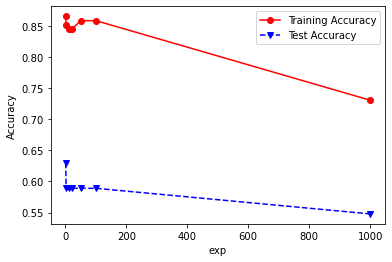

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from numpy.random import random

##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('C:/Users/33789/OneDrive/Desktop/Machine Learning/glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter exp for kNN

exp_range = [1, 2, 10, 20, 50,  100, 1000]

trainAcc = np.zeros(len(k_range))
testAcc = np.zeros(len(k_range))
trainAcc_norm = np.zeros(len(k_range))
testAcc_norm = np.zeros(len(k_range))



index = 0 
for k  in  k_range:
    clf = kNN(k)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

index = 0

knn = kNN()
X_test, X_train = knn.normalize(X_test, X_train)
for m in k_range: 
    clf = kNN(k)
    #we can only normalize the training data, we can never use before the testing teh test set, Y_train only contains the true class teh instances should be classified thus it is not normalized 
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc_norm[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc_norm[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
    
   
    
#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--', trainAcc_norm, 'g', testAcc_norm, 'c')
plt.legend(['Training Accuracy','Test Accuracy', 'Norm Train Acc', 'Norm Test Acc'])
#use logarithmic scale to make the changes more visible 
plt.xscale("log")
plt.xlabel('exp')
plt.ylabel('Accuracy')
plt.show()

This graph plots the accuracy performance on both data sets with different exponents used in the Minkowski distance. We tested for an interval where the exponent was between 2 and 1000. 
From this graph we can see there is a slight moment of volatility in accuracy when the exponent is less than 100, and after this point the overall perfomance steadily decreases. 
Thus I would like to take a closer look when the exp belongs [1, 100]

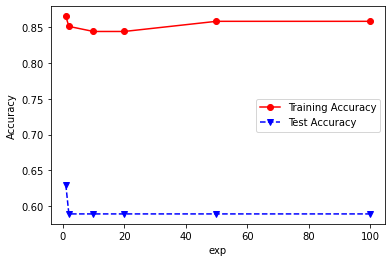

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from numpy.random import random

##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('C:/Users/33789/OneDrive/Desktop/Machine Learning/glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter exp for kNN

exp_range = [1, 2, 10, 20, 50,  100]

trainAcc = np.zeros(len(k_range))
testAcc = np.zeros(len(k_range))
trainAcc_norm = np.zeros(len(k_range))
testAcc_norm = np.zeros(len(k_range))



index = 0 
for k  in  k_range:
    clf = kNN(k)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

index = 0

knn = kNN()
X_test, X_train = knn.normalize(X_test, X_train)
for m in k_range: 
    clf = kNN(k)
    #we can only normalize the training data, we can never use before the testing teh test set, Y_train only contains the true class teh instances should be classified thus it is not normalized 
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc_norm[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc_norm[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
    
    
#########################################
# Plot of training and test accuracies
#########################################
plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--', trainAcc_norm, 'g', testAcc_norm, 'c')
plt.legend(['Training Accuracy','Test Accuracy', 'Norm Train Acc', 'Norm Test Acc'])
#use logarithmic scale to make the changes more visible 
plt.xscale("log")
plt.xlabel('exp')
plt.ylabel('Accuracy')
plt.show()

For training accuracy we can see that normalized data performs worse than non-normalized. ANd therefore does not improve the accuracy. However, for teh test data the normalized performs better for a small amount of exp, but we must not forget that the sacle is also changed to logarithmic to have a better view of smaller changes. 

['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
         preg      plas      pres      skin      insu      mass      pedi  \
659  0.176471  0.402010  0.672131  0.313131  0.082742  0.509687  0.533884   
439  0.352941  0.537688  0.721311  0.000000  0.000000  0.548435  0.300413   
72   0.764706  0.633166  0.737705  0.000000  0.000000  0.646796  0.240909   
329  0.352941  0.527638  0.573770  0.323232  0.080378  0.459016  0.050413   
692  0.117647  0.608040  0.573770  0.323232  0.112293  0.582712  0.366116   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.058824  0.668342  0.836066  0.282828  0.165485  0.488823  0.096694   
320  0.235294  0.648241  0.491803  0.121212  0.273050  0.409836  0.217769   
527  0.176471  0.582915  0.606557  0.151515  0.124113  0.391952  0.044215   
125  0.058824  0.442211  0.245902  0.424242  0.117021  0.819672  0.204959   
265  0.294118  0.482412  0.606557  0.181818  0.079196  0.500745  0.411983   

          a

['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
         preg      plas      pres      skin      insu      mass      pedi  \
659  0.176471  0.402010  0.672131  0.313131  0.082742  0.509687  0.533884   
439  0.352941  0.537688  0.721311  0.000000  0.000000  0.548435  0.300413   
72   0.764706  0.633166  0.737705  0.000000  0.000000  0.646796  0.240909   
329  0.352941  0.527638  0.573770  0.323232  0.080378  0.459016  0.050413   
692  0.117647  0.608040  0.573770  0.323232  0.112293  0.582712  0.366116   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.058824  0.668342  0.836066  0.282828  0.165485  0.488823  0.096694   
320  0.235294  0.648241  0.491803  0.121212  0.273050  0.409836  0.217769   
527  0.176471  0.582915  0.606557  0.151515  0.124113  0.391952  0.044215   
125  0.058824  0.442211  0.245902  0.424242  0.117021  0.819672  0.204959   
265  0.294118  0.482412  0.606557  0.181818  0.079196  0.500745  0.411983   

          a

['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']
         preg      plas      pres      skin      insu      mass      pedi  \
659  0.176471  0.402010  0.672131  0.313131  0.082742  0.509687  0.533884   
439  0.352941  0.537688  0.721311  0.000000  0.000000  0.548435  0.300413   
72   0.764706  0.633166  0.737705  0.000000  0.000000  0.646796  0.240909   
329  0.352941  0.527638  0.573770  0.323232  0.080378  0.459016  0.050413   
692  0.117647  0.608040  0.573770  0.323232  0.112293  0.582712  0.366116   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.058824  0.668342  0.836066  0.282828  0.165485  0.488823  0.096694   
320  0.235294  0.648241  0.491803  0.121212  0.273050  0.409836  0.217769   
527  0.176471  0.582915  0.606557  0.151515  0.124113  0.391952  0.044215   
125  0.058824  0.442211  0.245902  0.424242  0.117021  0.819672  0.204959   
265  0.294118  0.482412  0.606557  0.181818  0.079196  0.500745  0.411983   

          a

Text(0, 0.5, 'Accuracy')

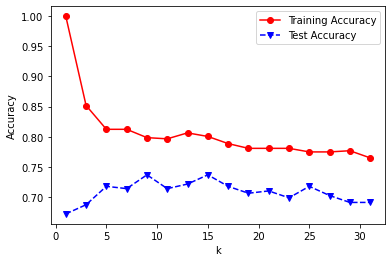

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('C:/Users/33789/OneDrive/Desktop/Machine Learning/diabetes.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter k for kNN

k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

trainAcc = np.zeros(len(k_range))
testAcc = np.zeros(len(k_range))


index = 0 
for k  in  k_range:
    clf = kNN(k)
    clf.fit(X_train, Y_train)
    clf.normalize(X_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
   
    
#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('k')
plt.ylabel('Accuracy')


In [6]:
from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_absolute_error(y_true, y_pred)

0.5